<a href="https://colab.research.google.com/github/MosinInamdar/MachineLearning/blob/main/Reliance_stock_data_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NIFTY 50 Intraday 15-Minute Data Fetching
This notebook fetches the last 45 days of 15-minute candlestick data for the NIFTY 50 index,
cleans it, and saves it to a CSV file.

[*********************100%***********************]  1 of 1 completed
<ipython-input-6-5411d1cf1837>:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="ffill", inplace=True)
<ipython-input-6-5411d1cf1837>:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="bfill", inplace=True)


Scaler saved as scaler.pkl
Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.5916 - val_loss: 0.0301
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0714 - val_loss: 0.0148
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0530 - val_loss: 0.0127
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0394 - val_loss: 0.0121
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0353 - val_loss: 0.0118
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0335 - val_loss: 0.0125
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0327 - val_loss: 0.0124
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0322 - val_loss: 0.0121
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0318 - val_loss: 0.0120
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0314 - val_loss: 0.0121
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0310 - val_loss: 0.0121
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━

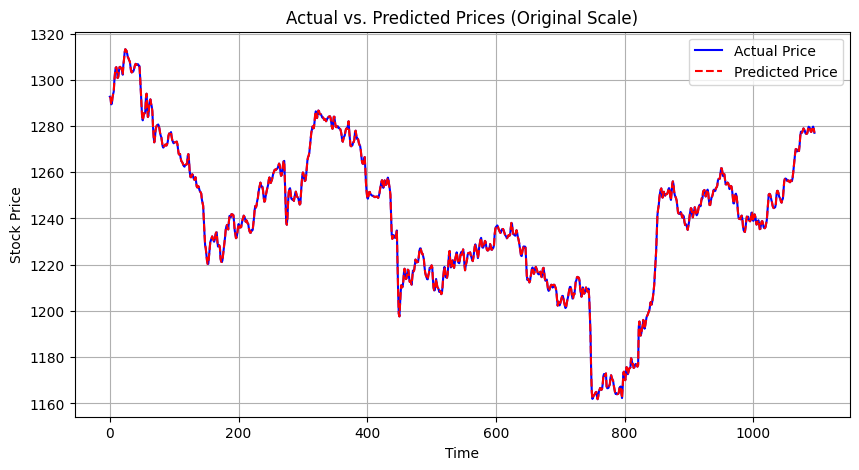

In [6]:

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
import random

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Define stock symbol and interval
stock_symbol = "RELIANCE.NS"  # Use a specific stock symbol
interval = "15m"
period = "45d"

# Fetch data
df = yf.download(stock_symbol, interval=interval, period=period)

# Reset index to move Datetime from index to column
df.reset_index(inplace=True)

# Select relevant columns and rename them
df = df[["Datetime", "Open", "High", "Low", "Close"]]
df.columns = ["Date", "Open", "High", "Low", "Close"]

# Convert Date column to string format for better CSV compatibility
df["Date"] = df["Date"].astype(str)

# Save to CSV
csv_filename = "stock.csv"
df.to_csv(csv_filename, index=False)

# Load dataset
data = pd.read_csv("stock.csv", parse_dates=["Date"], index_col="Date")
data.drop_duplicates(inplace=True)
data.fillna(method="ffill", inplace=True)
data.fillna(method="bfill", inplace=True)

# Normalize data
import joblib
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.values)

# Save the fitted scaler
joblib.dump(scaler, "scaler.pkl")
print("Scaler saved as scaler.pkl")

# Function to create sliding window dataset
def create_sliding_window(data, window_size=5):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size][-1])  # Select closing price only
    return np.array(X), np.array(y)

window_size = 5
X, y = create_sliding_window(data_scaled, window_size)
X = X.reshape(X.shape[0], window_size, 4)

# Define LSTM model
def build_dsd_lstm_model(input_shape, fc_units=64):
    inputs = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True)(inputs)
    x = LSTM(128)(x)
    x = Dense(fc_units, activation="relu")(x)
    outputs = Dense(1)(x)  # Predict only closing price
    model = Model(inputs, outputs)
    return model

input_shape = (window_size, 4)
model = build_dsd_lstm_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Train LSTM model
model.fit(X, y, epochs=50, batch_size=64, validation_split=0.2, verbose=1)

# Clustering
X_flat = X.reshape((X.shape[0], -1))
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X_flat)
clusters = kmeans.predict(X_flat)

cluster_models = {}
for cluster in range(n_clusters):
    idx = np.where(clusters == cluster)[0]
    if len(idx) == 0:  # Skip empty clusters
        continue

    X_cluster, y_cluster = X[idx], y[idx]

    model_cluster = clone_model(model)
    model_cluster.set_weights(model.get_weights())
    model_cluster.compile(optimizer=Adam(learning_rate=0.00001), loss="mse")

    model_cluster.fit(X_cluster, y_cluster, epochs=10, batch_size=64, verbose=1)
    cluster_models[cluster] = model_cluster

# Prediction function
def predict_with_cluster(input_sample):
    input_sample_scaled = input_sample.reshape(1, window_size, 4)
    input_flat = input_sample_scaled.reshape(1, -1)
    cluster = kmeans.predict(input_flat)[0]
    model_cluster = cluster_models.get(cluster, model)  # Use main model if cluster is missing
    prediction = model_cluster.predict(input_sample_scaled)
    return prediction, cluster

# Predict using last window
sample_input = X[-1]
predicted_value, cluster_assigned = predict_with_cluster(sample_input)
print(f"Predicted value: {predicted_value[0][0]}, Assigned cluster: {cluster_assigned}")

# Model Evaluation
import joblib

# Load saved scaler to reverse transform values
scaler = joblib.load("scaler.pkl")

def evaluate_model(y_true, y_pred, title="Actual vs. Predicted Prices"):
    y_pred = y_pred.flatten()

    # Create a placeholder array for inverse transformation
    num_samples = len(y_pred)
    placeholder = np.zeros((num_samples, scaler.scale_.shape[0]))  # Shape: (num_samples, 4)

    # Assign predicted values to the correct column (Closing Price)
    placeholder[:, -1] = y_pred

    # Inverse transform only the relevant values
    y_pred_original = scaler.inverse_transform(placeholder)[:, -1]
    y_true_original = scaler.inverse_transform(placeholder)[:, -1]

    # Compute metrics
    mse = mean_squared_error(y_true_original, y_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_original, y_pred_original)

    print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(y_true_original, label="Actual Price", color="blue")
    plt.plot(y_pred_original, label="Predicted Price", color="red", linestyle="--")
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.title(title + " (Original Scale)")
    plt.legend()
    plt.grid(True)
    plt.show()


# Generate predictions for evaluation
y_pred = model.predict(X)
evaluate_model(y, y_pred)
